In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 5000)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# https://github.com/bubblebooy/chi20_ds14/blob/master/curriculum/project-02/web-scraping-beautifulsoup/web_scraping_beautifulsoup.ipynb
from bs4 import BeautifulSoup
import requests

from tqdm.notebook import tqdm

import time, os

In [2]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [3]:
# https://github.com/bubblebooy/chi20_ds14/blob/master/curriculum/project-02/web-scraping-selenium/web_scraping_selenium.ipynb
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

chromedriver = "C:\Program Files (x86)\Google\Chrome\Application\chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

# Helper Functions

In [4]:
def scrape_browse(page = 1):
    """
    Get scrapes data from BBG browse with specified page.
    browse page is sorted by descending number of votes
    """
    url = f'https://boardgamegeek.com/browse/boardgame/page/{page}?sort=numvoters&sortdir=desc' 
    response = requests.get(url)
    page = response.text
    return BeautifulSoup(page, 'lxml')

In [5]:
def clean_column_str(col):
    """
    removes ( tabs and newlines ) and strips strings in a column
    """    
    return col.str.replace("\t","").str.replace("\n","").str.strip()

In [6]:
def list_get_text(soup_list):
    """
    Gets the textContent from each item in a list of html elements. Returns a list
    """
    return [item.text for item in soup_list]

In [7]:
def browse_html_to_df(soup):
    """
    Takes the html from a BBG browse page and return the relevant information as a DataFrame
    """
    _df = pd.DataFrame()
    _df["title"] = [ element.text for element in soup.select(".collection_objectname a") ]
    _df["link"] = [ element.get("href") for element in soup.select(".collection_objectname a") ]
    _df["date"] = [ element.text for element in soup.select(".collection_objectname span") ]
    _df["BGG_rank"] = [ element.text for element in soup.select(".collection_rank") ]  # so many tabs
    _df["geek_rating"] = [ element.select(".collection_bggrating")[0].text for element in soup.select("tr#row_") ]
    _df["avg_rating"] = [ element.select(".collection_bggrating")[1].text for element in soup.select("tr#row_") ]
    _df["num_votes"] = [ element.select(".collection_bggrating")[2].text for element in soup.select("tr#row_") ]

    _df["date"] = _df["date"].str.replace("(","").str.replace(")","")
    _df["BGG_rank"] = clean_column_str(_df["BGG_rank"])
    _df["geek_rating"] = clean_column_str(_df["geek_rating"])
    _df["avg_rating"] = clean_column_str(_df["avg_rating"])
    _df["num_votes"] = clean_column_str(_df["num_votes"])
    _df = _df[_df.BGG_rank != 'N/A']    #games with no rank will be dropped / these are expansions
    _df = _df.dropna()                  
    return _df

In [8]:
def game_page_info(_df):
    """
    Takes a Datafram w/ information from a BBG browse page and scrapes additional information for each game in the DataFrame from the games BGG game page
    """
    driver = webdriver.Chrome(chromedriver)
    for i,link in enumerate(tqdm(_df["link"], leave  = False)):
        url = 'https://boardgamegeek.com' + link + '/credits'
        driver.get(url)
        time.sleep(.5 + np.random.random()*5 )
        soup_game_page      = BeautifulSoup(driver.page_source, 'html.parser')
        _df.at[i,"players"]  =soup_game_page.find_all(class_ = "gameplay-item-primary")[0].find('span').text
        _df.at[i,"play_time"]=soup_game_page.find_all(class_ = "gameplay-item-primary")[1].find('span').text
        _df.at[i,"age"]      =soup_game_page.find_all(class_ = "gameplay-item-primary")[2].find('span').text

        max_wait_time = 5.0
        while max_wait_time:
            try:
                full_credits = soup_game_page.find_all(class_ = "global-body-content-primary")[1]
                designer_list =  list_get_text(full_credits.find_all(class_ = 'outline-item-description')[3].find(class_ = "ng-scope").find_all(class_ = "ng-scope"))
                artists_list =   list_get_text(full_credits.find_all(class_ = 'outline-item-description')[4].find(class_ = "ng-scope").find_all(class_ = "ng-scope"))
                publishers_list = list_get_text(full_credits.find_all(class_ = 'outline-item-description')[5].find(class_ = "ng-scope").find_all(class_ = "ng-scope"))  
                categories_list = list_get_text(full_credits.find_all(class_ = 'outline-item-description')[6].find(class_ = "ng-scope").find_all(class_ = "ng-scope"))  
                mechanisms_list =   list_get_text(full_credits.find_all(class_ = 'outline-item-description')[7].find(class_ = "ng-scope").find_all(class_ = "ng-scope"))
                family_list = list_get_text(full_credits.find_all(class_ = 'outline-item-description')[8].find(class_ = "ng-scope").find_all(class_ = "ng-scope")) 
                break
            except:
                driver.get(url)
                soup_game_page = BeautifulSoup(driver.page_source, 'html.parser')
                print(f'{url} not loaded waiting : {max_wait_time} seconds')
                designer_list = [""]
                artists_list = [""]
                publishers_list = [""]
                categories_list = [""]
                mechanisms_list = [""]
                family_list = [""]
                time.sleep(.5)
                max_wait_time -= .5

        _df.at[i, "designer"]   = " , ".join(designer_list)    
        _df.at[i, "artists"]    = " , ".join(artists_list)    
        _df.at[i, "publishers"] = " , ".join(publishers_list)    
        _df.at[i, "categories"] = " , ".join(categories_list)    
        _df.at[i, "mechanisms"] = " , ".join(mechanisms_list)    
        _df.at[i, "family"]     = " , ".join(family_list)

    driver.quit()
    _df["players"] = clean_column_str(_df["players"])
    _df["play_time"] = clean_column_str(_df["play_time"])
    _df["age"] = clean_column_str(_df["age"])
    return _df

In [9]:
def frist_value_from_csv_col(col):
    """
    Takes a Column of Comma Seperated Value(CSV) strings and return a Column with the frist value from each CSV
    """
    def frist_value(li):
        return li[0].strip()
    return col.str.split(" , ").map(frist_value)  # .str.strip()

In [10]:
def number_of_items_csv_col(col):
    """
    Takes a Column of Comma Seperated Value(CSV) strings and return a Column with the number of values in each CSV
    """
    return col.str.split(" , ").map(len)

In [11]:
def value_counts_from_csv_col(col):
    """
    Takes a Column of Comma Seperated Value(CSV) strings and return the Value Counts of the entire column
    """
    _df = pd.Series( " , ".join(col).split(" , ") ).str.strip()
    
    _df = _df[_df != "Admin: Better Description Needed!"]
    _df = _df[_df != 'N/A']
    
    return _df.value_counts()

In [12]:
def csv_col_get_dummies(column, counts_min = 20, max_dummies = None):
    """
    Takes a Column of Comma Seperated Value(CSV) strings and return a many_hot encoding DataFrame. (like a one_hot_encoding but allows multiple categories for each entry)
    """
    value_counts = value_counts_from_csv_col(column)
    columns = value_counts[value_counts > counts_min][:max_dummies].index
    _df = pd.DataFrame(columns = columns)
    for col in columns:
        _df[col] = column.str.find(col) + 1
    return _df.astype(bool)*1

# Data Scraping

In [13]:
# Set to True for web scraping otherwise read pickle
if False:
    #Set True to concat web scraping to pickle
    if True:
        df = pd.read_pickle("./bbg_df.pkl")
    else:
        df = pd.DataFrame()
    for page in tqdm(range(0,21)):  #page 21 does not work. random pages after also fail.
        soup = scrape_browse(page)
        df = pd.concat([df , game_page_info(browse_html_to_df(soup))])
        df.to_pickle("./bbg_df.pkl")
    df.shape
else:
    df = pd.read_pickle("./bbg_df.pkl")

# EDA , Data Cleaning, Feature Engineering

## Remove NaN and NaN like values

In [14]:
df = df.replace("NaN",np.nan)
df = df.replace(r'^\s*$', np.nan, regex=True)
df = df.dropna()
df = df.reset_index(drop=True)
df.isnull().sum(axis = 0).to_frame().T

,title,link,date,BGG_rank,geek_rating,avg_rating,num_votes,players,play_time,age,designer,artists,publishers,categories,mechanisms,family
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
print(df.shape)
df.head()

(1710, 16)


,title,link,date,BGG_rank,geek_rating,avg_rating,num_votes,players,play_time,age,designer,artists,publishers,categories,mechanisms,family
0,Catan,/boardgame/13/catan,1995,365,7.006,7.17,93231,3–4,60–120 Min,10+,Klaus Teuber,"Volkan Baga , Tanja Donner , Pete Fenlon ...","KOSMOS , 999 Games , Albi , Astrel Game...","Economic , Negotiation","Dice Rolling , Hexagon Grid , Income , ...","Catan , Promotional Board Games"
1,Carcassonne,/boardgame/822/carcassonne,2000,165,7.313,7.42,92924,2–5,30–45 Min,7+,Klaus-Jürgen Wrede,"Doris Matthäus , Anne Pätzke , Chris Quil...","Hans im Glück , 999 Games , Albi , Bard...","City Building , Medieval , Territory Buil...","Area Majority / Influence , Map Addition ,...","Carcassonne , Country: France , Languedoc..."
2,Pandemic,/boardgame/30549/pandemic,2008,86,7.523,7.62,92641,2–4,45 Min,8+,Matt Leacock,"Josh Cappel , Christian Hanisch , Régis M...","Z-Man Games, Inc. , (Unknown) , Albi , ...",Medical,"Action Points , Cooperative Game , Hand M...",Pandemic
3,7 Wonders,/boardgame/68448/7-wonders,2010,49,7.667,7.76,76940,2–7,30 Min,10+,Antoine Bauza,"Antoine Bauza , Miguel Coimbra","Repos Production , ADC Blackfire Entertainm...","Ancient , Card Game , City Building , C...","Card Drafting , Drafting , Hand Managemen...","7 Wonders , Tableau Building"
4,Dominion,/boardgame/36218/dominion,2008,84,7.527,7.63,73229,2–4,30 Min,13+,Donald X. Vaccarino,"Matthias Catrein , Julien Delval , Tomasz...","Rio Grande Games , 999 Games , Albi , B...","Card Game , Medieval","Deck, Bag, and Pool Building , Delayed Purc...","Crowdfunding: Wspieram , Dominion , Mensa..."


## Convert String columns from web scraping into various numeric columns

In [16]:
X = pd.DataFrame() 

df["date"] = pd.to_numeric(df["date"])
X['date'] = df['date']

df["age"] = df["age"].str.replace("+","")
df["age"] = pd.to_numeric(df["age"], errors = 'coerce' )
df["age"] = df["age"].fillna(df['age'].mean())
X["age"] = df['age']

df["play_time"] = df["play_time"].str.replace("Min","").str.strip()
df_play_time = df["play_time"].str.split("–" , expand = True)
X['min_play_time'] = df_play_time[0].astype(int)
X['max_play_time'] = df_play_time[1]
X['max_play_time'] = X['max_play_time'].fillna(X['min_play_time']).astype(int)

df_players = df["players"].str.split("–" , expand = True)
X['min_players'] = df_players[0].astype(int)
X['max_players'] = df_players[1]
X['max_players'] = X['max_players'].fillna(X['min_players']).astype(int)

df['designer'] = frist_value_from_csv_col(df.designer)  # if there are muliple desigers just pretend there is only one

X['number_of_mech'] = number_of_items_csv_col(df.mechanisms)
X['number_of_pub'] = number_of_items_csv_col(df.publishers)
X['number_of_cat'] = number_of_items_csv_col(df.categories)

In [17]:
df["geek_rating"] = pd.to_numeric(df["geek_rating"])
y = df["geek_rating"]

In [18]:
_df = df[['date','designer']].sort_values(by= 'date', ascending=True)
_df['designer_number_of_games'] = _df['designer']
_df['designer_number_of_games'] = _df.groupby('designer')['designer_number_of_games'].cumcount()
X['designer_number_of_games'] = _df['designer_number_of_games'] * (_df['designer'] != '(Uncredited)').astype(int)
# df_merge = df.merge(value_counts_from_csv_col(df.designer).rename('designer_number_of_games'),
#                     left_on = 'designer',
#                     right_index = True,
#                     how = 'left')

## Droped Games from Before 1900

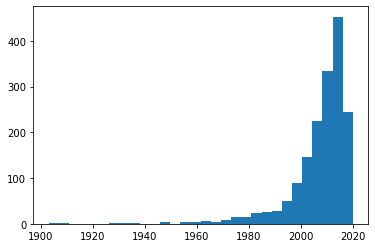

In [21]:
#dorp pre-historic games\
X = X.loc[(df["date"] > 1900)]
y = y.loc[(df["date"] > 1900)]
plt.hist(X["date"],bins = 30);

## Visualization of Data

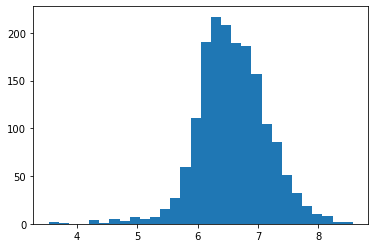

In [19]:
plt.hist(y,bins = 30);

In [20]:
print(X.shape)
print(y.shape)
X.head()

(1710, 10)
(1710,)


,date,age,min_play_time,max_play_time,min_players,max_players,number_of_mech,number_of_pub,number_of_cat,designer_number_of_games
0,1995,10.0,60,120,3,4,9,41,2,2
1,2000,7.0,30,45,2,5,3,31,3,1
2,2008,8.0,45,45,2,4,7,32,1,1
3,2010,10.0,30,30,2,7,6,14,4,4
4,2008,13.0,30,30,2,4,5,23,2,1


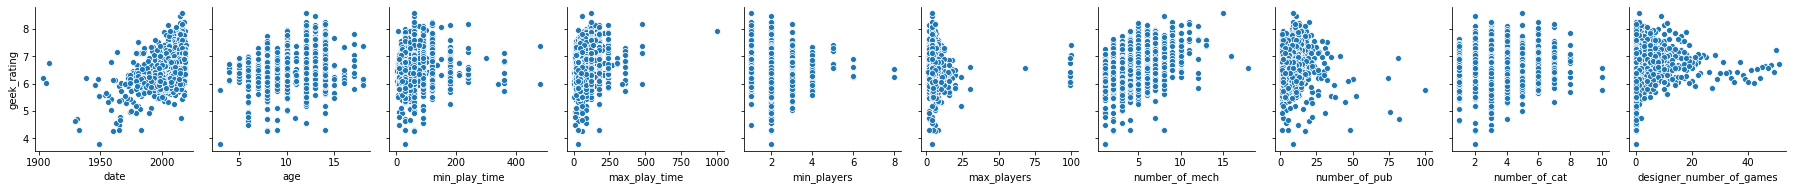

In [22]:
sns.pairplot(pd.concat([y,X],axis = 1),y_vars=y.name,x_vars=X.columns)
#insights
#Date: Games have been getting better
#Complex games higher rating
    #BGG bias?
    #age: weak correlation 
    #number or mech
    #number of cat
    #play time ** 0.5
#not a obvious correlation with designer number of games, higly proflific designer make very average games

## Create dummy columns

In [23]:
#csv_col_get_dummies(df.artists ,max_dummies = 10).head().add_prefix("artists_")
df_dummies = pd.DataFrame()
df_dummies = pd.concat([df_dummies ,
                csv_col_get_dummies(df.publishers,max_dummies = 30).add_prefix("pub_all_")] ,
               axis = 1)
df_dummies = pd.concat([df_dummies ,
                csv_col_get_dummies(df.categories,max_dummies = 30).add_prefix("cat_")],
               axis = 1)
df_dummies = pd.concat([df_dummies ,
                csv_col_get_dummies(df.mechanisms,max_dummies = 30).add_prefix("mech_")],
               axis = 1)
#looking at LARS plot these do not seem to add anything 
#RMSE: with 0.4272588495420052 // without: 0.43027682820751334
df_dummies = pd.concat([df_dummies ,
                csv_col_get_dummies(frist_value_from_csv_col(df.publishers),max_dummies = 10).add_prefix("pub_1st_")],
               axis = 1) 
df_dummies = pd.concat([df_dummies ,
                csv_col_get_dummies(df.family, max_dummies = 1)],
               axis = 1) # .add_prefix("family_")
df_dummies = df_dummies.loc[(df["date"] > 1900)]
print(df_dummies.shape)
df_dummies.head()

(1689, 101)


,pub_all_Edge Entertainment,pub_all_Asmodee,pub_all_999 Games,pub_all_Devir,"pub_all_Korea Boardgames co., Ltd.",pub_all_Hobby World,pub_all_Rio Grande Games,pub_all_Pegasus Spiele,pub_all_Heidelberger Spieleverlag,pub_all_Kaissa Chess & Games,pub_all_Rebel,"pub_all_Z-Man Games, Inc.",pub_all_Arclight,pub_all_Hobby Japan,"pub_all_Swan Panasia Co., Ltd.",pub_all_Fantasy Flight Games,pub_all_Asterion Press,pub_all_Filosofia Éditions,pub_all_IELLO,pub_all_Galápagos Jogos,pub_all_Lautapelit.fi,pub_all_MINDOK,pub_all_Giochi Uniti,pub_all_Galakta,pub_all_Piatnik,pub_all_KOSMOS,pub_all_White Goblin Games,pub_all_Gém Klub Kft.,pub_all_Hasbro,pub_all_Ravensburger Spieleverlag GmbH,cat_Card Game,cat_Fantasy,cat_Economic,cat_Fighting,cat_Science Fiction,cat_Adventure,cat_Medieval,cat_Dice,cat_Wargame,cat_Bluffing,cat_Exploration,cat_City Building,cat_Party Game,cat_Deduction,cat_Miniatures,cat_Animals,cat_Territory Building,cat_Ancient,cat_Humor,cat_Abstract Strategy,cat_Civilization,cat_Horror,cat_Negotiation,cat_Political,cat_Nautical,cat_Novel-based,cat_Movies / TV / Radio theme,cat_Real-time,cat_Industry / Manufacturing,cat_Action / Dexterity,mech_Hand Management,mech_Dice Rolling,mech_Variable Player Powers,mech_Set Collection,mech_Card Drafting,mech_Area Majority / Influence,mech_Modular Board,mech_Tile Placement,mech_Cooperative Game,mech_Worker Placement,mech_Grid Movement,mech_Action Points,mech_Auction/Bidding,mech_Simultaneous Action Selection,mech_Team-Based Game,mech_Area Movement,mech_Take That,"mech_Deck, Bag, and Pool Building",mech_Push Your Luck,mech_Solo / Solitaire Game,mech_Point to Point Movement,mech_Network and Route Building,mech_Player Elimination,mech_Role Playing,mech_Pick-up and Deliver,mech_Trading,mech_Memory,mech_Pattern Building,mech_Roll / Spin and Move,mech_Simulation,pub_1st_Fantasy Flight Games,pub_1st_999 Games,pub_1st_Hans im Glück,pub_1st_Asmodee,pub_1st_KOSMOS,pub_1st_Alderac Entertainment Group,pub_1st_AMIGO,pub_1st_alea,pub_1st_(Public Domain),pub_1st_Queen Games,Crowdfunding: Kickstarter
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,1,1,1,1,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,1,0,1,1,0,0,1,0,1,1,1,0,1,0,0,1,1,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,1,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


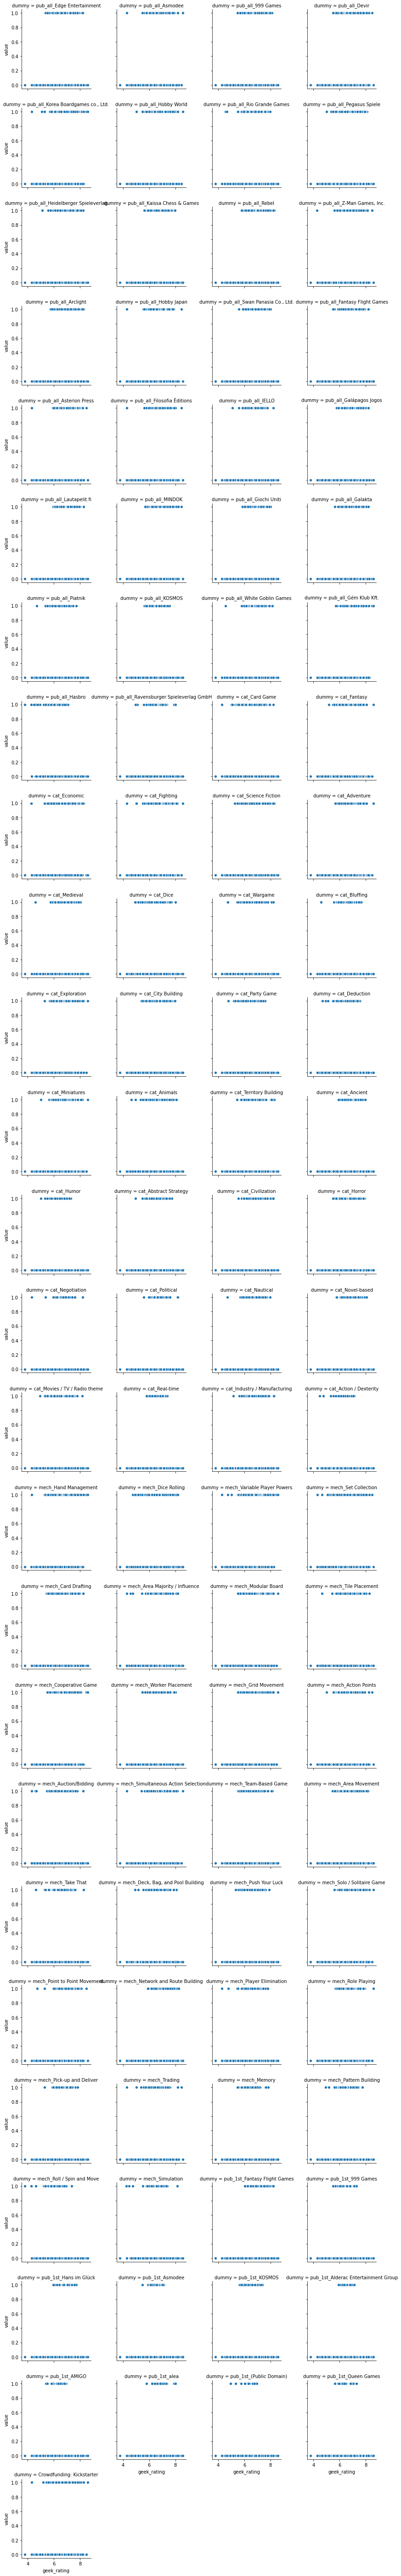

In [24]:
grid_dummies = sns.FacetGrid(data = pd.melt(pd.concat([y,df_dummies],axis = 1),id_vars=['geek_rating'],var_name = "dummy"), col = "dummy",col_wrap = 4)
grid_dummies.map(sns.scatterplot,'geek_rating','value')

In [25]:
X.isnull().sum(axis = 0).to_frame().T

,date,age,min_play_time,max_play_time,min_players,max_players,number_of_mech,number_of_pub,number_of_cat,designer_number_of_games
0,0,0,0,0,0,0,0,0,0,0


# Test Train Split

In [29]:
X_tr, X_te, dummies_tr, dummies_te ,y_tr, y_te = train_test_split(X, df_dummies, y, test_size=0.2 , random_state=42)

# Transform Data

In [30]:
#RMSE with: 0.4234980192846648 // without: 0.4272588495420052
# poly = PolynomialFeatures(2)
# X_tr = poly.fit_transform(X_tr)
# X_test = poly.transform(X_test)
#columns = np.concatenate([poly.get_feature_names(columns),np.array(dummies_train.columns)])

columns = np.array(X_tr.columns)
## I should have subtracted the min(val) or the mean for at leat the date before **2 , prob somthing before the sqrt too
columns = np.concatenate([np.array(X_tr.columns),
                          np.array(X_tr.columns)+"**2",
                          np.array(X_tr.columns)+"_sqrt",
#                           np.array(X_tr.columns)+"_log",
                         ])

#RMSE with:  // without: 
def transform_X(array):
    array = np.hstack((array,
                      array**2,
                      array**.5,
#                         np.log(np.where( _df == 0 , 1 , _df))
                      ))
    return array


X_tr = transform_X(X_tr)
X_te = transform_X(X_te)


columns = np.concatenate([columns,np.array(dummies_tr.columns)])

### Mask for ignoring columns

In [32]:
col_mask = columns.astype(bool)

# col_mask_con from doing fit on only continuous values
# by continuous I mean quantitative
col_mask_con = np.array([-1.01742556e-02,  1.23387527e-02, -7.59644930e-03,  3.62161861e-03,
       -0.00000000e+00, -2.09878625e-02,  5.36154194e-02,  2.00392129e-02,
       -3.74917506e-03, -7.05966983e-03,  7.26969324e-06, -0.00000000e+00,
        8.60769382e-06, -5.04524817e-06,  4.14717665e-03,  2.24769531e-04,
        8.41760914e-04, -3.53847098e-04, -1.48795685e-03, -2.96535858e-05,
       -0.00000000e+00,  0.00000000e+00,  8.13808496e-02,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  1.01621070e-01,
       -0.00000000e+00,  5.03776810e-02]).astype(bool)
# col_mask_dummies from doing fit on only dummy values
col_mask_dummies = np.array([-0.00674781,  0.06505208,  0.14145388,  0.08323992,  0.15380765,
        0.03884024, -0.        ,  0.        ,  0.03904317,  0.01886973,
        0.19902899,  0.02239348,  0.11668354,  0.02393544,  0.01578265,
       -0.07660926,  0.11767579,  0.09563061, -0.        ,  0.11215603,
        0.06699802,  0.15508915,  0.13532958,  0.00453299, -0.        ,
       -0.        ,  0.08378772,  0.2082326 , -0.35013131,  0.11816803,
       -0.13834373,  0.        ,  0.17302991, -0.        ,  0.06579703,
        0.        ,  0.02919113, -0.06679666,  0.01937507,  0.00331384,
       -0.03465005, -0.00452476,  0.05340364,  0.07233949,  0.10428879,
       -0.03347434,  0.        , -0.11844248,  0.09799374, -0.02285268,
        0.03251356, -0.04443575, -0.01974605,  0.09801091,  0.01052277,
        0.03205493,  0.01489164, -0.        ,  0.        , -0.04375278,
        0.07067423,  0.06216375,  0.00545207, -0.04056102,  0.1265504 ,
        0.02486299,  0.01956994,  0.02677931, -0.00316175,  0.18456254,
        0.07991841, -0.01647413,  0.06097649,  0.09996392,  0.01802035,
        0.0072478 ,  0.03966428,  0.08365854,  0.23179847,  0.00788636,
        0.02743867,  0.05040812, -0.        ,  0.03534354, -0.10339285,
       -0.00314235, -0.01037254, -0.04959509, -0.1777596 ,  0.        ,
        0.23262064, -0.18338026,  0.04856201, -0.18171225, -0.12088072,
        0.        ,  0.        ,  0.0093376 ,  0.13855213, -0.0343699 ,
        0.16507067,  0.07035781,  0.13812066,  0.09072879]).astype(bool)
# col_mask[:30] = col_mask_con #rmse Before: 0.41073081002113787 // After: 0.41227129158523657
# col_mask[30:] = col_mask_dummies #rmse Before: 0.41073081002113787 // After: 0.41107348554113876
# col_mask[0:30:10] = False
# Both #rmse Before: 0.41073081002113787 // After: 0.4120623501620755
#columns[col_mask][:30]

In [33]:
col_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

# Normalize Data

In [34]:
standar_scaler = StandardScaler()
X_tr = standar_scaler.fit_transform(X_tr)
X_te = standar_scaler.transform(X_te)

In [35]:
print(X_tr.shape, X_te.shape, dummies_tr.shape, dummies_te.shape ,y_tr.shape, y_te.shape)
pd.DataFrame(X_tr,columns=columns[:30]).head()

(1351, 30) (338, 30) (1351, 101) (338, 101) (1351,) (338,)


,date,age,min_play_time,max_play_time,min_players,max_players,number_of_mech,number_of_pub,number_of_cat,designer_number_of_games,date**2,age**2,min_play_time**2,max_play_time**2,min_players**2,max_players**2,number_of_mech**2,number_of_pub**2,number_of_cat**2,designer_number_of_games**2,date_sqrt,age_sqrt,min_play_time_sqrt,max_play_time_sqrt,min_players_sqrt,max_players_sqrt,number_of_mech_sqrt,number_of_pub_sqrt,number_of_cat_sqrt,designer_number_of_games_sqrt
0,0.930627,1.277604,1.421235,1.907005,-1.447903,-0.207035,0.404708,0.255698,1.276968,1.264270,0.939132,1.367078,0.727465,1.409925,-0.895969,-0.092510,0.125964,-0.054638,1.131057,0.324997,0.926348,1.214558,1.558126,1.862217,-1.680908,-0.303635,0.529439,0.517538,1.256176,1.624471
1,0.771789,-0.358667,-0.232037,-0.482746,-1.447903,-0.207035,0.856203,0.119426,-0.662894,-0.491155,0.777914,-0.462823,-0.244831,-0.375579,-0.895969,-0.092510,0.551696,-0.094001,-0.634027,-0.219204,0.768701,-0.295316,-0.118327,-0.437893,-1.680908,-0.303635,0.931281,0.359306,-0.609013,-0.818095
2,0.295277,0.459468,0.098617,-0.217218,1.389105,-0.207035,0.404708,-0.698201,-0.662894,-0.012403,0.295220,0.375881,-0.121084,-0.282997,1.106022,-0.092510,0.125964,-0.232931,-0.634027,-0.178726,0.295288,0.491243,0.291390,-0.082065,1.385187,-0.303635,0.529439,-0.944946,-0.609013,0.457494
3,0.851208,-2.404005,-0.232037,-0.482746,-0.029399,-0.207035,-0.046787,-0.016845,-0.662894,-0.491155,0.858503,-1.892434,-0.244831,-0.375579,-0.145222,-0.092510,-0.222363,-0.128734,-0.634027,-0.219204,0.847534,-2.709035,-0.118327,-0.437893,0.053969,-0.303635,0.084957,0.190834,-0.609013,-0.818095
4,0.295277,0.868536,0.759926,0.313838,-1.447903,0.081618,0.404708,-0.698201,-1.309514,-0.491155,0.295220,0.852418,0.232478,-0.018478,-0.895969,-0.062446,0.125964,-0.232931,-0.886181,-0.219204,0.295288,0.859863,0.978698,0.514844,-1.680908,0.322583,0.529439,-0.944946,-1.549066,-0.818095


# Regression

## Dummy Regressor

In [920]:
model = DummyRegressor(strategy="mean")
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv = cross_validate(model, X = X_train, y = y_tr, cv=kf, scoring=['r2','neg_mean_squared_error'],return_train_score = True)
print(np.mean(cv['test_r2']))
print(np.mean(np.sqrt(-1 *cv['test_neg_mean_squared_error'])))

-0.0026993549731780587
0.5572528936951456


## Linear Regression w/ Gird Search over L1 and L2 regularization

In [36]:
%%capture --no-display
## fit
lmbd_list = 10**(np.linspace(-4,1,51))
a_list = np.linspace(0,1,11)
dummy_scale_list = np.array([2]) # also searched over scale factor for dummy variables. 

test_r2 = np.empty((lmbd_list.size,a_list.size, dummy_scale_list.size))
train_r2 = np.empty((lmbd_list.size,a_list.size, dummy_scale_list.size))
test_rmse = np.empty((lmbd_list.size,a_list.size, dummy_scale_list.size))
train_rmse = np.empty((lmbd_list.size,a_list.size, dummy_scale_list.size))

for i,lmbd in enumerate(tqdm(lmbd_list, position = 0)):  
    for j, a in enumerate(tqdm(a_list, position = 2, leave = False)):  
        for k, dummy_scale in enumerate(tqdm(dummy_scale_list, position = 1, leave = False)):
            X_train = np.concatenate([X_tr, dummy_scale * dummies_tr],axis = 1)
            X_train = X_train[:,col_mask]
            model = ElasticNet(alpha = lmbd, l1_ratio = a, random_state=0,max_iter=1000)
            kf = KFold(n_splits=5, shuffle=True, random_state = 71)
            cv = cross_validate(model, X_train, y_tr, cv=kf, scoring=['r2','neg_mean_squared_error'],return_train_score = True)
            test_r2[i,j,k] = np.mean(cv['test_r2'])
            train_r2[i,j,k] = np.mean(cv['train_r2'])
            test_rmse[i,j,k] = np.mean(np.sqrt(-1 *cv['test_neg_mean_squared_error']))
            train_rmse[i,j,k] = np.mean(np.sqrt(-1 *cv['train_neg_mean_squared_error']))
            #score[i,j] = np.mean(np.sqrt(-1 * cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')))

In [37]:
print(test_r2[(38,0)])
print(train_r2[(38,0)])
print(lmbd_list[38])

[0.42086237]
[0.46000073]
0.6309573444801936


### R2 heat map

0.4509201198079357
0.5253245245650404
(30, 0, 0)


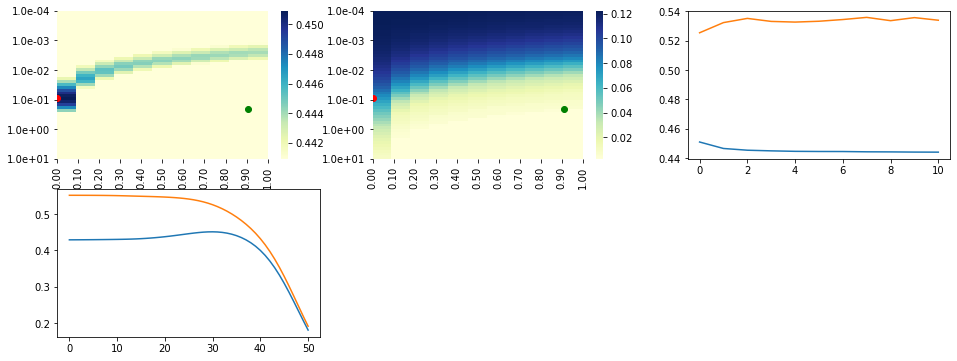

In [38]:
print(test_r2.max())
argmin = np.unravel_index(np.argmin(test_r2, axis=None), test_r2.shape)
argmax = np.unravel_index(np.argmax(test_r2, axis=None), test_r2.shape)
print(train_r2[argmax])
print(argmax)


fig = plt.figure(figsize = (16,6))
plt.subplot(2,3,1)
sns.heatmap(np.amax(test_r2,2), #test_r2[:,:,argmax[2]],
            cmap="YlGnBu",
            vmin=test_r2.max()-.01, vmax=test_r2.max(),
#             center=.2,
            xticklabels = ['{:.2f}'.format(i) for i in a_list],
            yticklabels = ['{:.1e}'.format(i) for i in lmbd_list[0::10]])
plt.scatter(argmin[1],argmin[0],c='g')
plt.scatter(argmax[1],argmax[0],c='r')
plt.xticks(np.linspace(0,11,11));
plt.yticks(np.linspace(0,51,6));

plt.subplot(2,3,2)
sns.heatmap(np.abs(np.amax(test_r2,2) - np.amax(train_r2,2)), #test_r2[:,:,argmax[2]],
            cmap="YlGnBu",
#             vmin=test_r2.max()-.01, vmax=test_r2.max(),
#             center=.2,
            xticklabels = ['{:.2f}'.format(i) for i in a_list],
            yticklabels = ['{:.1e}'.format(i) for i in lmbd_list[0::10]])
plt.scatter(argmin[1],argmin[0],c='g')
plt.scatter(argmax[1],argmax[0],c='r')
plt.xticks(np.linspace(0,11,11));
plt.yticks(np.linspace(0,51,6));
# sns.heatmap(np.amax(test_r2,0),
#             cmap="YlGnBu",
#             vmin=test_r2.max()-.01, vmax=test_r2.max())
plt.subplot(2,3,3)

am = np.argmax(test_r2,axis=0) 
plt.plot(np.max(test_r2,axis=0))
plt.plot([train_r2[am[i],i,0] for i in range(test_r2.shape[1])])
bottom, top = plt.ylim() 

plt.subplot(2,3,4)
plt.plot(test_r2[:,0,0])
plt.plot(train_r2[:,0,0])
# plt.ylim((bottom, top))

# plt.subplot(2,3,5)
# plt.plot(test_r2[:,1,0])
# plt.plot(train_r2[:,1,0])
# plt.ylim((bottom, top))

# plt.subplot(2,3,6)
# plt.plot(test_r2[:,2,0])
# plt.plot(train_r2[:,2,0])
# plt.ylim((bottom, top))


# sns.heatmap(np.amax(test_r2,1),
#             cmap="YlGnBu",
#             vmin=test_r2.max()-.01, vmax=test_r2.max())

#plt.scatter()

### RMSE heat map

0.41156703435507697
0.3838700430712202
(30, 0, 0)


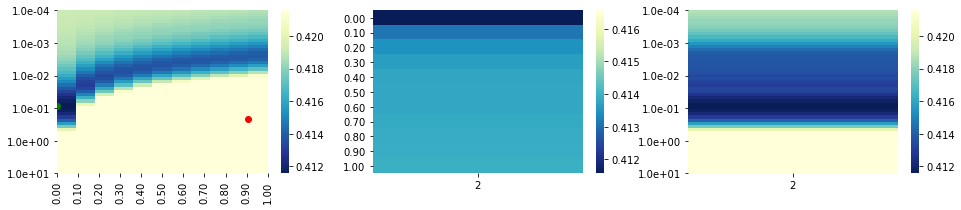

In [39]:
print(test_rmse.min())
argmin = np.unravel_index(np.argmin(test_rmse, axis=None), test_rmse.shape)
argmax = np.unravel_index(np.argmax(test_rmse, axis=None), test_rmse.shape)
print(train_rmse[argmin])
print(argmin)

fig = plt.figure(figsize = (16,3))
plt.subplot(1,3,1)
sns.heatmap(np.amin(test_rmse,2), #test_rmse[:,:,argmin[2]]
            cmap="YlGnBu_r",
            vmin=test_rmse.min(), vmax=test_rmse.min()+.01,
            xticklabels = ['{:.2f}'.format(i) for i in a_list],
            yticklabels = ['{:.1e}'.format(i) for i in lmbd_list[0::10]])
plt.scatter(argmin[1],argmin[0],c='g')
plt.scatter(argmax[1],argmax[0],c='r')
plt.xticks(np.linspace(0,11,11));
plt.yticks(np.linspace(0,51,6));

plt.subplot(1,3,2)
sns.heatmap(np.amin(test_rmse,0),
            cmap="YlGnBu_r",
            vmin=test_rmse.min(), vmax=test_rmse.min()+0.005,
            xticklabels=dummy_scale_list,
            yticklabels = ['{:.2f}'.format(i) for i in a_list])           
plt.subplot(1,3,3)

sns.heatmap(np.amin(test_rmse,1),
            cmap="YlGnBu_r",
            vmin=test_rmse.min(), vmax=test_rmse.min()+.01,
            xticklabels=dummy_scale_list,
            yticklabels = ['{:.1e}'.format(i) for i in lmbd_list[0::10]])
plt.yticks(np.linspace(0,51,6));

### Best Fit

In [74]:
X_train = np.concatenate([X_tr, dummy_scale_list[argmin[2]] * dummies_tr],axis = 1)
X_train = X_train[:,col_mask]
model = ElasticNet(alpha = lmbd_list[argmin[0]], l1_ratio = a_list[argmin[1]], random_state=3,max_iter=1000)
# model = ElasticNet(alpha = lmbd_list[38], l1_ratio = a_list[argmin[1]], random_state=3,max_iter=1000)
model.fit(X_train,y_tr)
list(zip(columns[col_mask], model.coef_))

C:\Users\bubbl\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.07677566240335, tolerance: 0.0419606818611399
  positive)


[('date', 0.06591000335297839),
 ('age', 0.010312914938092018),
 ('min_play_time', -0.013686300477447226),
 ('max_play_time', 0.03431979536708604),
 ('min_players', 0.006295373047309299),
 ('max_players', 0.000837149856492685),
 ('number_of_mech', 0.06653902047913916),
 ('number_of_pub', 0.033650820550927565),
 ('number_of_cat', -0.0006073395653095283),
 ('designer_number_of_games', -0.008791749874141535),
 ('date**2', 0.07064137321266674),
 ('age**2', 0.009845828048898414),
 ('min_play_time**2', -0.017448640628020862),
 ('max_play_time**2', 0.0001991527597934737),
 ('min_players**2', 0.0014472388999482247),
 ('max_players**2', 0.04043575108049612),
 ('number_of_mech**2', 0.044036530598861326),
 ('number_of_pub**2', -0.05616232853611106),
 ('number_of_cat**2', -0.003528357649671477),
 ('designer_number_of_games**2', -0.01491618568497204),
 ('date_sqrt', 0.06350724001952017),
 ('age_sqrt', 0.010337441960001257),
 ('min_play_time_sqrt', 0.01346812930164674),
 ('max_play_time_sqrt', 0.060

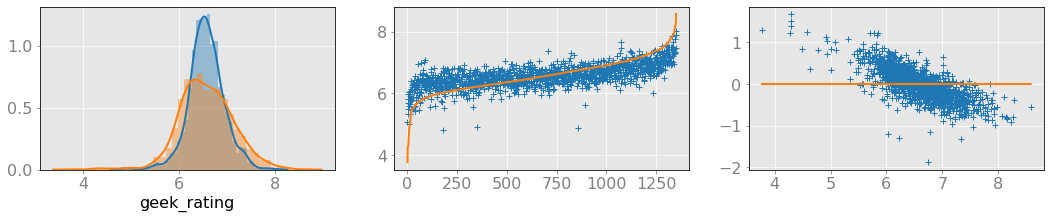

In [75]:
predict = model.predict(X_train)
fig = plt.figure(figsize = (18,3))
plt.subplot(1,3,1)
sns.distplot(predict)
sns.distplot(y_tr)
plt.subplot(1,3,2)
argsort = np.argsort(y_tr)
plt.plot(predict[argsort],'+')
plt.plot(np.array(y_tr)[argsort])
plt.subplot(1,3,3)
plt.plot(y_tr,np.squeeze(predict)-np.array(y_tr),'+')
plt.plot(y_tr,y_tr*0);

0.3228754687496351
0.48368983520747566


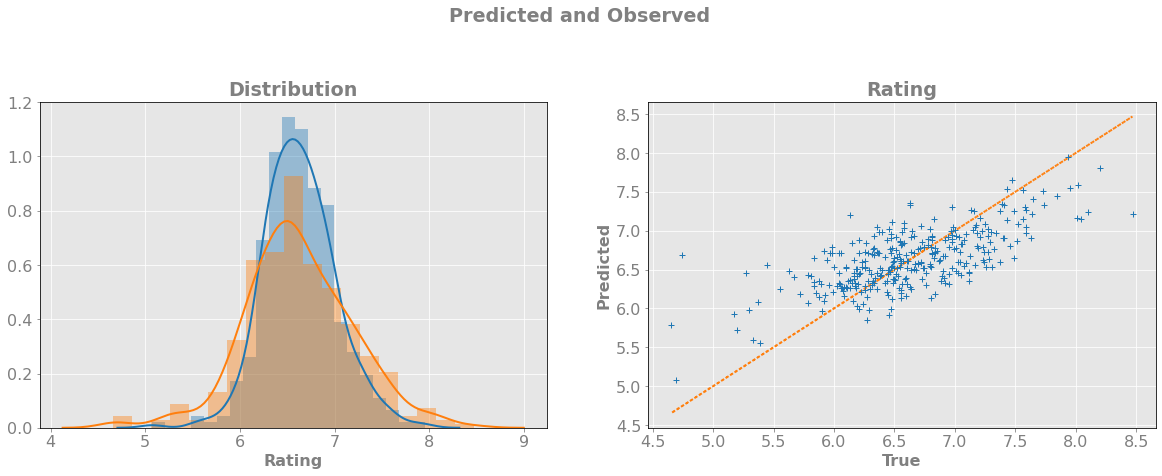

In [76]:
X_test = np.concatenate([X_te, dummy_scale_list[argmin[2]] * dummies_te],axis = 1)
predict = model.predict(X_test)
print(mean_absolute_error(y_te,predict))
print(r2_score(y_te,predict))

fig = plt.figure(figsize = (20,6),facecolor='k')
fig.suptitle("Predicted and Observed",color='grey',fontweight="bold", y=1.1)
fig.patch.set_alpha(0.0)


plt.subplot(1,2,1)
plt.title("Distribution",color='grey',fontweight="bold")
sns.distplot(predict)
sns.distplot(np.array(y_te))
# plt.ylabel("Predicted",color='grey',fontweight="bold")
plt.xlabel("Rating",color='grey',fontweight="bold")

plt.subplot(1,2,2) #,facecolor='lightgrey'
# plt.title("Sorted",color='grey',fontweight="bold")
# argsort = np.argsort(y_te)
# plt.plot(predict[argsort],'+')
# plt.plot(np.array(y_te)[argsort])
plt.title("Rating",color='grey',fontweight="bold")
argsort = np.argsort(y_te)
plt.plot(y_te,predict,'+')
plt.plot(y_te,y_te,':',zorder=1)
plt.ylabel("Predicted",color='grey',fontweight="bold")
plt.xlabel("True",color='grey',fontweight="bold")
# plt.facecolor('grey')
# plt.plot(np.array(y_te)[argsort])


plt.savefig("Predicted and Observed",transparent=False)

In [77]:
%%capture --no-display
x = np.linspace(-2,6,2001)
x = np.tile(x, (30, 1)).T
x_inverted = standar_scaler.inverse_transform(x)
#plt.plot(x[:,0],x_inverted[:,0])

In [78]:
# This is wrong
# %%capture --no-display
# fig = plt.figure(figsize = (25,10))
# for i in range(10):
#     plt.subplot(2,5,i+1)
#     plt.plot(x_inverted[:,i],model.coef_[i]*x[:,i] + model.coef_[i+10]*x[:,i+10]**2 + model.coef_[i+20]*x[:,i+20]**.5, linewidth = 5)
#     bottom, top = plt.ylim()
#     plt.ylim((bottom, top)) 
#     plt.xlim(max(0,plt.xlim()[0]))
#     plt.plot(x_inverted[:,i],model.coef_[i]*x[:,i])
#     plt.plot(x_inverted[:,i],(model.coef_[i+10]*x[:,i+10])**2)
#     plt.plot(x_inverted[:,i],(model.coef_[i+20]*x[:,i+20])**.5)
#     if i == 0:
#         plt.legend(["X + X^2 + sqrt(x)","X","X^2","sqrt(x)"])
    
# #     label(i)\
#     plt.title(columns[i])

In [79]:
plt.rc('axes', facecolor='#E6E6E6', edgecolor='k',
       axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray',labelsize=16)
plt.rc('ytick', direction='out', color='gray',labelsize=16)
plt.rcParams.update({'font.size': 16})
plt.rcParams['text.color'] = 'k'
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

C:\Users\bubbl\Anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt
C:\Users\bubbl\Anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt
C:\Users\bubbl\Anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in sqrt
C:\Users\bubbl\Anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt


Text(0.5, 1.0, 'Number of Players')

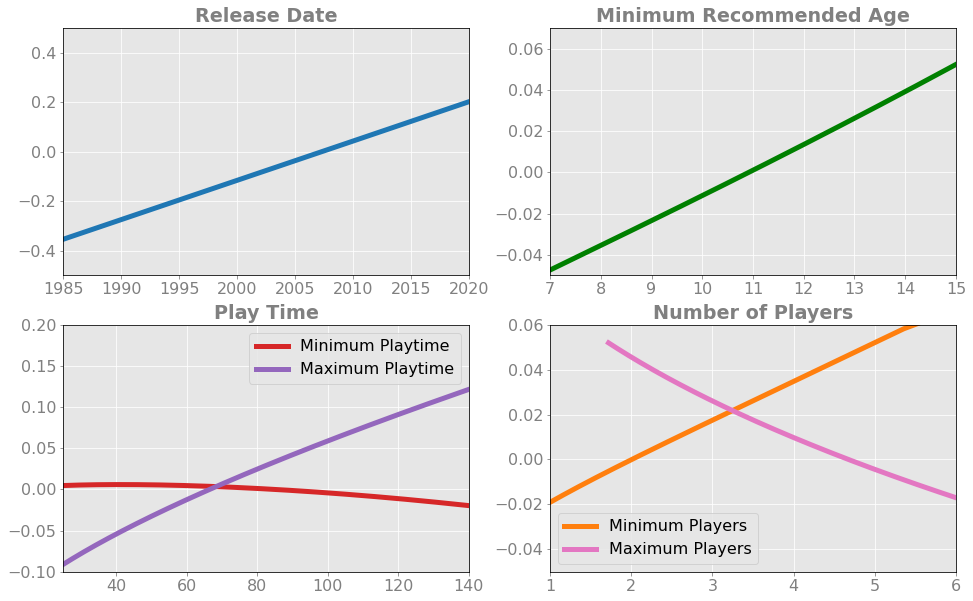

In [80]:
fig = plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
i = 0
y1=np.interp(x_inverted[:,i], x_inverted[:,i] , model.coef_[i]*x[:,i])
y2=np.interp(x_inverted[:,i], x_inverted[:,i+10]**.5 , model.coef_[i+10]*x[:,i+10])
y3=np.interp(x_inverted[:,i], x_inverted[:,i+20]**2 , model.coef_[i+20]*x[:,i+20])
plt.plot(x_inverted[:,i],y1+y2+y3,linewidth = 5)
# plt.plot(x_inverted[:,i],y1)
# plt.plot(x_inverted[:,i],y2)
# plt.plot(x_inverted[:,i],y3)
plt.xlim((1985,2020))
plt.ylim((-.5,.5))
# plt.legend(["x + x^2 + sqrt(x)","x","x^2","Sqrt(x)"]) # 
plt.title("Release Date",color='grey',fontweight="bold")

plt.subplot(2,2,2)
i = 1
y1=np.interp(x_inverted[:,i], x_inverted[:,i] , model.coef_[i]*x[:,i])
y2=np.interp(x_inverted[:,i], x_inverted[:,i+10]**.5 , model.coef_[i+10]*x[:,i+10])
y3=np.interp(x_inverted[:,i], x_inverted[:,i+20]**2 , model.coef_[i+20]*x[:,i+20])
plt.plot(x_inverted[:,i],y1+y2+y3,linewidth = 5,color = 'g')
# plt.plot(x_inverted[:,i],y1)
# plt.plot(x_inverted[:,i],y2)
# plt.plot(x_inverted[:,i],y3)
plt.xlim((7,15))
plt.ylim((-.05,.07))
plt.title("Minimum Recommended Age",color='grey',fontweight="bold")
# plt.ylabel("Predicted",color='grey',fontweight="bold")
# plt.xlabel("Year",color='grey',fontweight="bold")

plt.subplot(2,2,3)
i = 2
y1=np.interp(x_inverted[:,i], x_inverted[:,i] , model.coef_[i]*x[:,i])
y2=np.interp(x_inverted[:,i], x_inverted[:,i+10]**.5 , model.coef_[i+10]*x[:,i+10])
y3=np.interp(x_inverted[:,i], x_inverted[:,i+20]**2 , model.coef_[i+20]*x[:,i+20])
plt.plot(x_inverted[:,i],y1+y2+y3,linewidth = 5,color = 'tab:red')
i = 3
y1=np.interp(x_inverted[:,i], x_inverted[:,i] , model.coef_[i]*x[:,i])
y2=np.interp(x_inverted[:,i], x_inverted[:,i+10]**.5 , model.coef_[i+10]*x[:,i+10])
y3=np.interp(x_inverted[:,i], x_inverted[:,i+20]**2 , model.coef_[i+20]*x[:,i+20])
plt.plot(x_inverted[:,i],y1+y2+y3,linewidth = 5,color = 'tab:purple')
plt.xlim((25,140))
plt.ylim((-.1,.2))
plt.legend(["Minimum Playtime","Maximum Playtime"]) # 
plt.title("Play Time",color='grey',fontweight="bold")

plt.subplot(2,2,4)
i = 4
y1=np.interp(x_inverted[:,i], x_inverted[:,i] , model.coef_[i]*x[:,i])
y2=np.interp(x_inverted[:,i], x_inverted[:,i+10]**.5 , model.coef_[i+10]*x[:,i+10])
y3=np.interp(x_inverted[:,i], x_inverted[:,i+20]**2 , model.coef_[i+20]*x[:,i+20])
plt.plot(x_inverted[:,i],y1+y2+y3,linewidth = 5,color = 'tab:orange')
i = 5
y1=np.interp(x_inverted[:,i], x_inverted[:,i] , model.coef_[i]*x[:,i])
y2=np.interp(x_inverted[:,i], x_inverted[:,i+10]**.5 , model.coef_[i+10]*x[:,i+10])
y3=np.interp(x_inverted[:,i], x_inverted[:,i+20]**2 , model.coef_[i+20]*x[:,i+20])
plt.plot(x_inverted[:,i],y1+y2+y3,linewidth = 5,color = 'tab:pink')
# plt.plot(x_inverted[:,i],y1)
# plt.plot(x_inverted[:,i],y2)
# plt.plot(x_inverted[:,i],y3)
plt.xlim((1,6))
plt.ylim((-.05,.06))
plt.legend(["Minimum Players","Maximum Players"]) # 
plt.title("Number of Players",color='grey',fontweight="bold")

C:\Users\bubbl\Anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


Text(0.5, 0, 'Number of Mechanics')

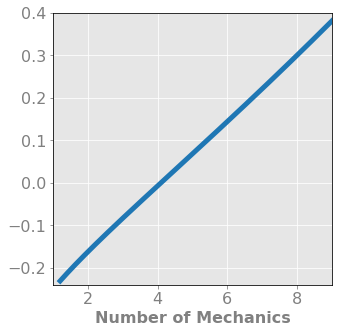

In [81]:
fig = plt.figure(figsize = (5,5))
# plt.subplot(1,2,1) 
i = 6
y1=np.interp(x_inverted[:,i], x_inverted[:,i] , model.coef_[i]*x[:,i])
y2=np.interp(x_inverted[:,i], x_inverted[:,i+10]**.5 , model.coef_[i+10]*x[:,i+10])
y3=np.interp(x_inverted[:,i], x_inverted[:,i+20]**2 , model.coef_[i+20]*x[:,i+20])
plt.plot(x_inverted[:,i],y1+y2+y3,linewidth = 5)
# plt.plot(x_inverted[:,i],y1)
# plt.plot(x_inverted[:,i],y2)
# plt.plot(x_inverted[:,i],y3)
plt.xlim((1,9
         ))
plt.ylim((-.24,.4))
#plt.legend(["x + x^2 + sqrt(x)","x","x^2","Sqrt(x)"]) # 
# plt.title("Number of Mechanics",color='grey',fontweight="bold")
# plt.ylabel("Predicted",color='grey',fontweight="bold")
plt.xlabel("Number of Mechanics",color='grey',fontweight="bold")
# plt.subplot(1,2,2)
# plt.bar([label[4:] for label in columns[60:90]],model.coef_[60:90])
# plt.xticks(rotation=90);

C:\Users\bubbl\Anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


Text(0.5, 0, 'Number of Categories')

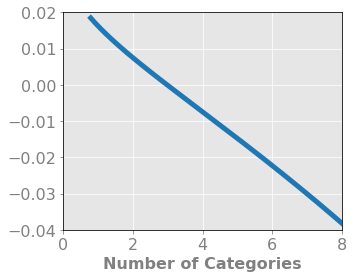

In [82]:
fig = plt.figure(figsize = (5,4))
# plt.subplot(1,2,1) 
i = 8
y1=np.interp(x_inverted[:,i], x_inverted[:,i] , model.coef_[i]*x[:,i])
y2=np.interp(x_inverted[:,i], x_inverted[:,i+10]**.5 , model.coef_[i+10]*x[:,i+10])
y3=np.interp(x_inverted[:,i], x_inverted[:,i+20]**2 , model.coef_[i+20]*x[:,i+20])
plt.plot(x_inverted[:,i],y1+y2+y3,linewidth = 5)
# plt.plot(x_inverted[:,i],y1)
# plt.plot(x_inverted[:,i],y2)
# plt.plot(x_inverted[:,i],y3)
plt.xlim((0,8))
plt.ylim((-.04,.02))
#plt.legend(["x + x^2 + sqrt(x)","x","x^2","Sqrt(x)"]) # 
# plt.title("Number of Mechanics",color='grey',fontweight="bold")
# plt.ylabel("Predicted",color='grey',fontweight="bold")
plt.xlabel("Number of Categories",color='grey',fontweight="bold")
# plt.subplot(1,2,2)
# plt.bar([label[4:] for label in columns[60:90]],model.coef_[60:90])
# plt.xticks(rotation=90);

C:\Users\bubbl\Anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


array(['date', 'age', 'min_play_time', 'max_play_time', 'min_players',
       'max_players', 'number_of_mech', 'number_of_pub', 'number_of_cat',
       'designer_number_of_games'], dtype=object)

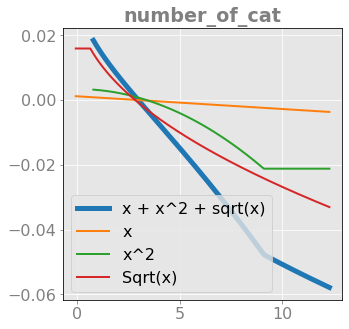

In [83]:

fig = plt.figure(figsize = (5,5))
# plt.subplot(1,2,1) 
i = 8
y1=np.interp(x_inverted[:,i], x_inverted[:,i] , model.coef_[i]*x[:,i])
y2=np.interp(x_inverted[:,i], x_inverted[:,i+10]**.5 , model.coef_[i+10]*x[:,i+10])
y3=np.interp(x_inverted[:,i], x_inverted[:,i+20]**2 , model.coef_[i+20]*x[:,i+20])
plt.plot(x_inverted[:,i],y1+y2+y3,linewidth = 5)
plt.plot(x_inverted[:,i],y1)
plt.plot(x_inverted[:,i],y2)
plt.plot(x_inverted[:,i],y3)
#plt.xlim((1,8))
plt.legend(["x + x^2 + sqrt(x)","x","x^2","Sqrt(x)"]) # 
plt.title(columns[i],color='grey',fontweight="bold")
# plt.subplot(1,2,2)
# plt.bar([label[4:] for label in columns[60:90]],model.coef_[60:90])
# plt.xticks(rotation=90);
columns[:10]

Text(0.5, 1.0, 'All Publisher')

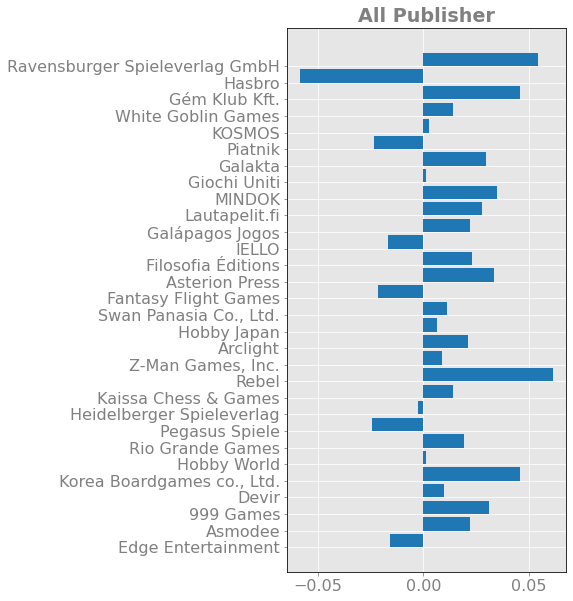

In [87]:
fig = plt.figure(figsize = (5,10))
ax = plt.barh([label[8:] for label in columns[30:60]],model.coef_[30:60], align = 'edge' )
# plt.xticks(rotation='vertical');
# plt.xticks(range(30),labels = [label[8:] for label in columns[30:60]], rotation='vertical');
plt.title('All Publisher',color='grey',fontweight="bold")

Text(0.5, 1.0, 'Category')

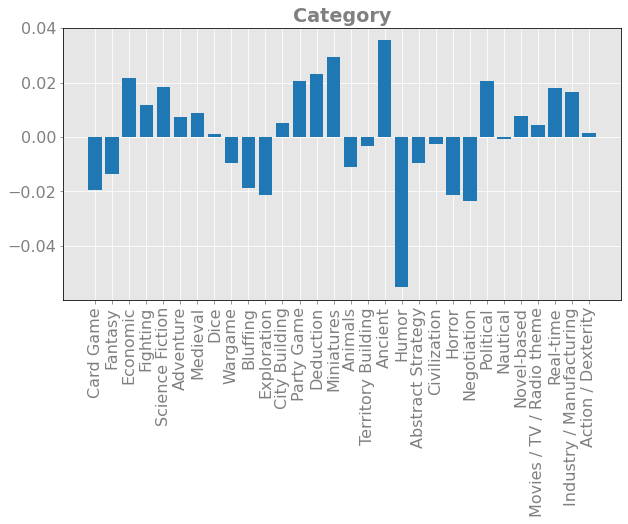

In [91]:
fig = plt.figure(figsize = (10,5))
plt.bar([label[4:] for label in columns[60:90]],model.coef_[60:90])
plt.xticks(rotation='vertical');
plt.title('Category',color='grey',fontweight="bold")
# plt.xticks(range(30),labels = [label[8:] for label in columns[30:60]], rotation='vertical');

mech_Dice Rolling


<BarContainer object of 30 artists>

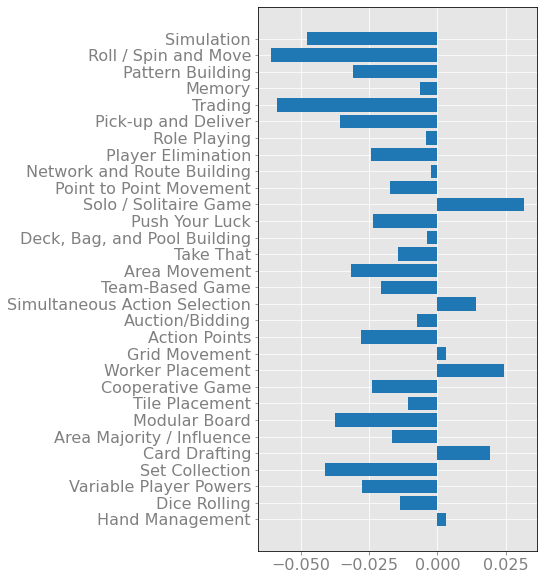

In [95]:
print(columns[91])
fig = plt.figure(figsize = (5,10))
plt.barh([label[5:] for label in columns[90:120]],model.coef_[90:120])
# plt.xticks(rotation='vertical');

Text(0.5, 1.0, 'Primary Publisher')

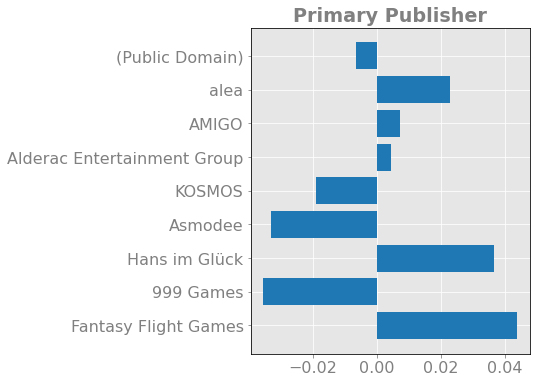

In [53]:
fig = plt.figure(figsize = (5,6))
plt.barh([label[8:] for label in columns[120:-2]],model.coef_[120:-2])
#plt.xticks(rotation='vertical');
plt.title('Primary Publisher',color='grey',fontweight="bold")

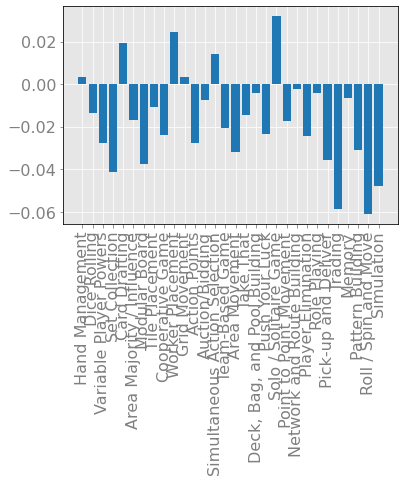

In [54]:
plt.bar([label[5:] for label in columns[90:120]],model.coef_[90:120])
plt.xticks(rotation='vertical');

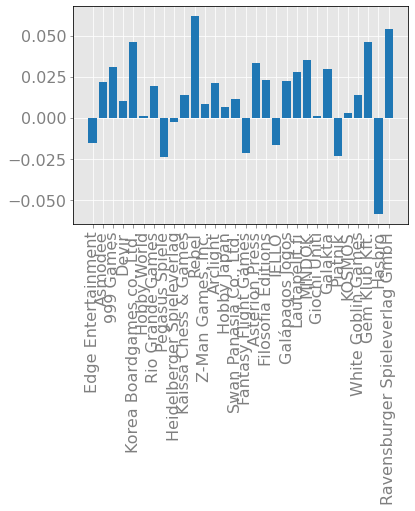

In [55]:
plt.bar([label[8:] for label in columns[30:60]],model.coef_[30:60])
plt.xticks(rotation='vertical');

### Fit: L1 Ratio = 1

In [56]:
X_train = np.concatenate([X_tr, dummy_scale_list[argmin[2]] * dummies_tr],axis = 1)
X_train = X_train[:,col_mask]
model = ElasticNet(alpha = lmbd_list[np.argmin(test_rmse[:,-1,0])], l1_ratio = 1, random_state=0,max_iter=1000)
model.fit(X_train,y_tr)
print(np.min(test_rmse[:,-1,0]))
list(zip(columns[col_mask], model.coef_))

0.41396047575758266


[('date', 0.0),
 ('age', 0.000733843907865046),
 ('min_play_time', -0.002800542323544137),
 ('max_play_time', 0.0),
 ('min_players', 0.0),
 ('max_players', 0.0),
 ('number_of_mech', 0.16521771802701915),
 ('number_of_pub', 0.0),
 ('number_of_cat', -0.0),
 ('designer_number_of_games', -0.0),
 ('date**2', 0.203801952596588),
 ('age**2', 0.02191755706077508),
 ('min_play_time**2', -0.018899635825181605),
 ('max_play_time**2', -0.0),
 ('min_players**2', 0.0),
 ('max_players**2', 0.053064339804302765),
 ('number_of_mech**2', 0.0),
 ('number_of_pub**2', -0.06402369896794714),
 ('number_of_cat**2', -0.0),
 ('designer_number_of_games**2', -0.01840020857044768),
 ('date_sqrt', 0.0),
 ('age_sqrt', 0.0),
 ('min_play_time_sqrt', 0.0),
 ('max_play_time_sqrt', 0.11255170193794474),
 ('min_players_sqrt', 0.0117800967181569),
 ('max_players_sqrt', -0.058707489162236816),
 ('number_of_mech_sqrt', 0.02037598550080454),
 ('number_of_pub_sqrt', 0.15253556201640026),
 ('number_of_cat_sqrt', -0.001831208514

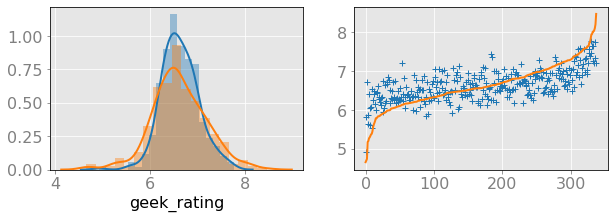

In [57]:
X_test = np.concatenate([X_te, dummy_scale_list[argmin[2]] * dummies_te],axis = 1)
predict = model.predict(X_test)
fig = plt.figure(figsize = (10,3))
plt.subplot(1,2,1)
sns.distplot(predict)
sns.distplot(y_te)
plt.subplot(1,2,2)
argsort = np.argsort(y_te)
plt.plot(predict[argsort],'+')
plt.plot(np.array(y_te)[argsort])

## Linear Regression w/ Gird Search: Without Dummy Variables

In [347]:
%%capture --no-display
## fit
lmbd_list = 10**(np.linspace(-4,1,51))
a_list = np.linspace(0,1,11)
dummy_scale_list = np.array([0])
#score = np.empty((lmbd_list.size,a_list.size))
test_r2_con = np.empty((lmbd_list.size,a_list.size, dummy_scale_list.size))
train_r2_con = np.empty((lmbd_list.size,a_list.size, dummy_scale_list.size))
test_rmse_con = np.empty((lmbd_list.size,a_list.size, dummy_scale_list.size))
train_rmse_con = np.empty((lmbd_list.size,a_list.size, dummy_scale_list.size))

for i,lmbd in enumerate(tqdm(lmbd_list, position = 0)):  
    for j, a in enumerate(tqdm(a_list, position = 2, leave = False)):  
        for k, dummy_scale in enumerate(tqdm(dummy_scale_list, position = 1, leave = False)):
            X_train = X_tr
            model = ElasticNet(alpha = lmbd, l1_ratio = a, random_state=0,max_iter=1000)
            kf = KFold(n_splits=5, shuffle=True, random_state = 71)
            cv = cross_validate(model, X_train, y_train, cv=kf, scoring=['r2','neg_mean_squared_error'],return_train_score = True)
            test_r2_con[i,j,k] = np.mean(cv['test_r2'])
            train_r2_con[i,j,k] = np.mean(cv['train_r2'])
            test_rmse_con[i,j,k] = np.mean(np.sqrt(-1 *cv['test_neg_mean_squared_error']))
            train_rmse_con[i,j,k] = np.mean(np.sqrt(-1 *cv['train_neg_mean_squared_error']))
            #score[i,j] = np.mean(np.sqrt(-1 * cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')))

0.39748371967557217
0.5386127033577573
(14, 9, 0)


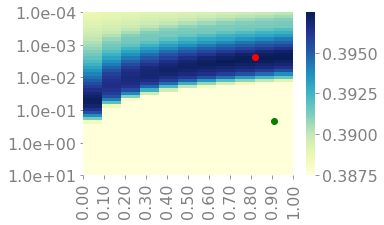

In [1261]:
print(test_r2_con.max())
#print(test_rmse_con.min())
argmin = np.unravel_index(np.argmin(test_r2_con, axis=None), test_r2_con.shape)
argmax = np.unravel_index(np.argmax(test_r2_con, axis=None), test_r2_con.shape)
print(train_r2[argmax])
print(argmax)

fig = plt.figure(figsize = (16,3))
plt.subplot(1,3,1)
sns.heatmap(np.amax(test_r2_con,2), #test_r2_con[:,:,argmax[2]],
            cmap="YlGnBu",
            vmin=test_r2_con.max()-.01, vmax=test_r2_con.max(),
#             center=.2,
            xticklabels = ['{:.2f}'.format(i) for i in a_list],
            yticklabels = ['{:.1e}'.format(i) for i in lmbd_list[0::10]])
plt.scatter(argmin[1],argmin[0],c='g')
plt.scatter(argmax[1],argmax[0],c='r')
plt.xticks(np.linspace(0,11,11));
plt.yticks(np.linspace(0,51,6));

In [1262]:
X_train = X_tr
model = ElasticNet(alpha = lmbd_list[argmax[0]], l1_ratio = a_list[argmax[1]], random_state=0,max_iter=1000)
model.fit(X_train,y_tr)
list(zip(columns[:30], model.coef_))

[('date', 0.0),
 ('age', 0.0),
 ('min_play_time', -0.03905763273468842),
 ('max_play_time', 0.0),
 ('min_players', 0.0),
 ('max_players', 0.0),
 ('number_of_mech', 0.13302626902144957),
 ('number_of_pub', 0.0),
 ('number_of_cat', -0.0),
 ('designer_number_of_games', -0.010300590242805342),
 ('date**2', 0.23139654400493959),
 ('age**2', 0.0),
 ('min_play_time**2', -0.0026226891619131163),
 ('max_play_time**2', -0.004809062660525614),
 ('min_players**2', 0.007479771274006316),
 ('max_players**2', 0.05130272730322299),
 ('number_of_mech**2', 0.009058577503202632),
 ('number_of_pub**2', -0.08766828804912839),
 ('number_of_cat**2', -0.008891073234060807),
 ('designer_number_of_games**2', -0.022678908163066627),
 ('date_sqrt', 0.0),
 ('age_sqrt', 0.031874721902090744),
 ('min_play_time_sqrt', 0.0),
 ('max_play_time_sqrt', 0.12817285711907558),
 ('min_players_sqrt', 0.0),
 ('max_players_sqrt', -0.055030785339421726),
 ('number_of_mech_sqrt', 0.0),
 ('number_of_pub_sqrt', 0.2077283110704234),


## Linear Regression w/ Gird Search: Only Dummy Variables

In [171]:
%%capture --no-display
## fit
lmbd_list = 10**(np.linspace(-4,1,51))
a_list = np.linspace(0,1,11)
dummy_scale_list = np.array([np.inf])
#score = np.empty((lmbd_list.size,a_list.size))
test_r2_dummy = np.empty((lmbd_list.size,a_list.size, dummy_scale_list.size))
train_r2_dummy = np.empty((lmbd_list.size,a_list.size, dummy_scale_list.size))
test_rmse_dummy = np.empty((lmbd_list.size,a_list.size, dummy_scale_list.size))
train_rmse_dummy = np.empty((lmbd_list.size,a_list.size, dummy_scale_list.size))

for i,lmbd in enumerate(tqdm(lmbd_list, position = 0)):  
    for j, a in enumerate(tqdm(a_list, position = 2, leave = False)):  
        for k, dummy_scale in enumerate(tqdm(dummy_scale_list, position = 1, leave = False)):
            X_train = dummies_tr
            model = ElasticNet(alpha = lmbd, l1_ratio = a, random_state=0,max_iter=1000)
            kf = KFold(n_splits=5, shuffle=True, random_state = 71)
            cv = cross_validate(model, X_train, y_train, cv=kf, scoring=['r2','neg_mean_squared_error'],return_train_score = True)
            test_r2_dummy[i,j,k] = np.mean(cv['test_r2'])
            train_r2_dummy[i,j,k] = np.mean(cv['train_r2'])
            test_rmse_dummy[i,j,k] = np.mean(np.sqrt(-1 *cv['test_neg_mean_squared_error']))
            train_rmse_dummy[i,j,k] = np.mean(np.sqrt(-1 *cv['train_neg_mean_squared_error']))
            #score[i,j] = np.mean(np.sqrt(-1 * cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')))

0.2809325696937211
0.5487020548998816
(18, 1, 0)


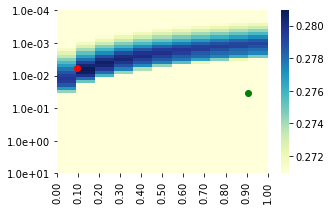

In [752]:
print(test_r2_dummy.max())
# print(test_rmse_dummy.min())
argmin = np.unravel_index(np.argmin(test_r2_dummy, axis=None), test_r2_dummy.shape)
argmax = np.unravel_index(np.argmax(test_r2_dummy, axis=None), test_r2_dummy.shape)
print(train_r2[argmax])
print(argmax)

fig = plt.figure(figsize = (16,3))
plt.subplot(1,3,1)
sns.heatmap(np.amax(test_r2_dummy,2), #test_r2_dummy[:,:,argmax[2]],
            cmap="YlGnBu",
            vmin=test_r2_dummy.max()-.01, vmax=test_r2_dummy.max(),
#             center=.2,
            xticklabels = ['{:.2f}'.format(i) for i in a_list],
            yticklabels = ['{:.1e}'.format(i) for i in lmbd_list[0::10]])
plt.scatter(argmin[1],argmin[0],c='g')
plt.scatter(argmax[1],argmax[0],c='r')
plt.xticks(np.linspace(0,11,11));
plt.yticks(np.linspace(0,51,6));

In [274]:
X_train = dummies_tr
model = ElasticNet(alpha = lmbd_list[argmax[0]], l1_ratio = a_list[argmax[1]], random_state=0,max_iter=1000)
model.fit(X_train,y_train)
list(zip(columns[30:], model.coef_))

[('pub_all_Edge Entertainment', -0.006747805794937381),
 ('pub_all_Asmodee', 0.06505208058421885),
 ('pub_all_999 Games', 0.1414538774493175),
 ('pub_all_Devir', 0.08323991933274105),
 ('pub_all_Korea Boardgames co., Ltd.', 0.1538076538010638),
 ('pub_all_Hobby World', 0.038840235926593185),
 ('pub_all_Rio Grande Games', -0.0),
 ('pub_all_Pegasus Spiele', 0.0),
 ('pub_all_Heidelberger Spieleverlag', 0.03904317436663953),
 ('pub_all_Kaissa Chess & Games', 0.018869732958484705),
 ('pub_all_Rebel', 0.19902899110140945),
 ('pub_all_Z-Man Games, Inc.', 0.022393477387530482),
 ('pub_all_Arclight', 0.11668353686110337),
 ('pub_all_Hobby Japan', 0.02393543868432445),
 ('pub_all_Swan Panasia Co., Ltd.', 0.015782648871129047),
 ('pub_all_Fantasy Flight Games', -0.07660926047957486),
 ('pub_all_Asterion Press', 0.11767579138165504),
 ('pub_all_Filosofia Éditions', 0.09563061458675624),
 ('pub_all_IELLO', -0.0),
 ('pub_all_Galápagos Jogos', 0.11215603473496376),
 ('pub_all_Lautapelit.fi', 0.066998

In [58]:
from sklearn.linear_model import lars_path
## %matplotlib notebook

In [59]:
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_tr.values, method='lasso')

Computing regularization path using the LARS ...


In [60]:
i = 0

date


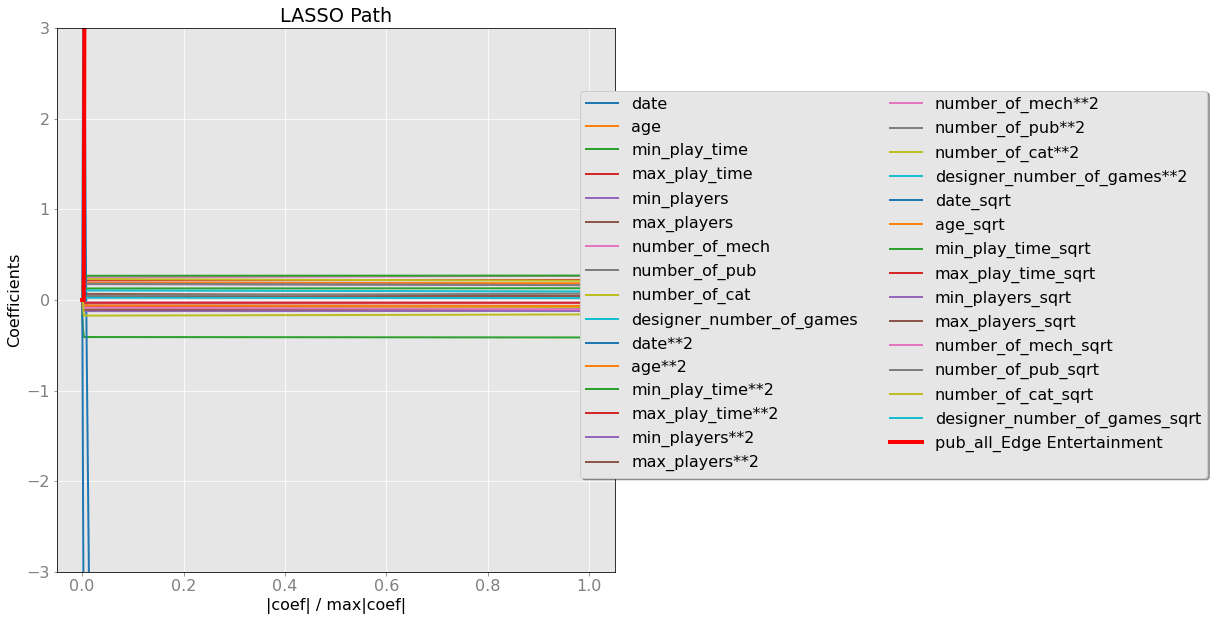

In [61]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

print(columns[i])
plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
plt.plot(xx, coefs[i].T, 'r',linewidth=4)
i = (i+1) % (len(columns)-1)
ymin, ymax = plt.ylim()
#plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(columns, loc='upper center', bbox_to_anchor=(1.5, .9),
           fancybox=True, shadow=True, ncol=2)
plt.ylim((-3, 3))

plt.show()

['age' 'age**2' 'age_sqrt']


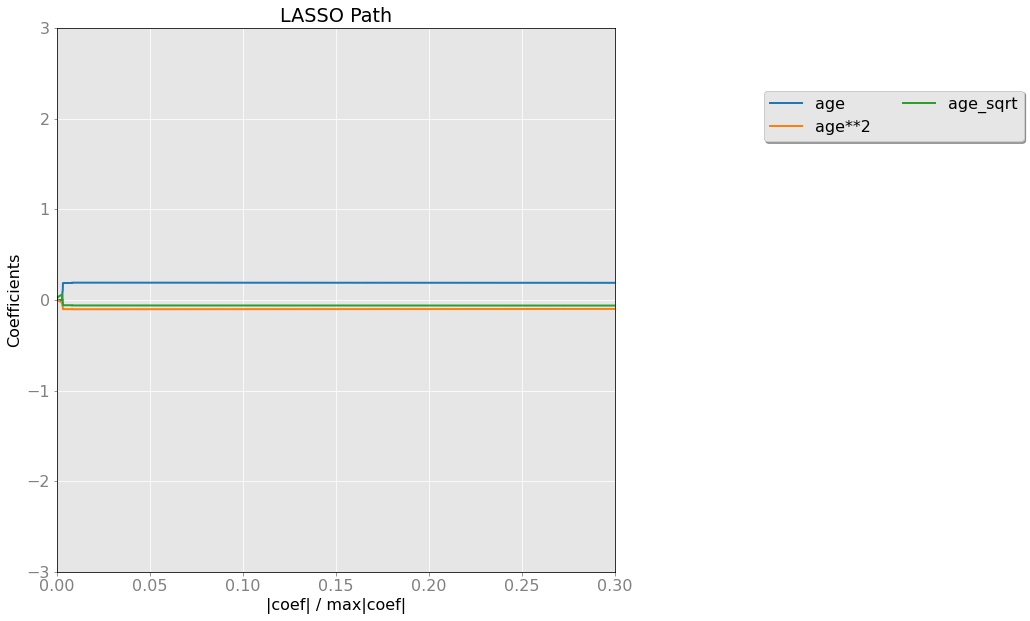

In [62]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

print(columns[i:30+i:10])
plt.figure(figsize=(10,10))
plt.plot(xx, coefs[i:30+i:10].T)
ymin, ymax = plt.ylim()
#plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(columns[i:30+i:10], loc='upper center', bbox_to_anchor=(1.5, .9),
           fancybox=True, shadow=True, ncol=2)
i = (i+1) % (len(columns)-1)
plt.ylim((-3, 3))
plt.xlim((0, .3))

plt.show()

# Neural Network

In [63]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD

C:\Users\bubbl\Anaconda3\envs\metis\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\bubbl\Anaconda3\envs\metis\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\bubbl\Anaconda3\envs\metis\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\bubbl\Anaconda3\envs\metis\lib\site-packages\tensorflow\python\f

In [67]:
X_train = np.concatenate([X_tr, dummies_tr],axis = 1)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_tr, test_size=0.25 , random_state=42)
X_train.shape

(1013, 131)

In [68]:
inputs = Input(shape=(131,))
reg = regularizers.l1_l2(l1=0.0001, l2=0.1)
x = Dense(100 , activation = "relu",bias_regularizer=reg, kernel_regularizer=reg)(inputs)
# x = Dropout(0.3)(x)
x = Dense(100 , activation = "relu",bias_regularizer=reg, kernel_regularizer=reg)(x)
# x = Dropout(0.3)(x)
x = Dense(100 , activation = "relu",bias_regularizer=reg, kernel_regularizer=reg)(x)
x = Dense(1)(x)
model = Model(inputs=inputs, outputs=x)
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['mse','mae'])

In [69]:
history = model.fit(X_train,y_train,epochs=100,validation_data=(X_val,y_val))

Train on 1013 samples, validate on 338 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1013/1013 [==============================] - 0s 366us/sample - loss: 35.3619 - mean_squared_error: 5.1041 - mean_absolute_error: 1.4637 - val_loss: 29.4817 - val_mean_squared_error: 1.1643 - val_mean_absolute_error: 0.8548
Epoch 2/100
1013/1013 [==============================] - 0s 54us/sample - loss: 27.1981 - mean_squared_error: 0.5089 - mean_absolute_error: 0.5533 - val_loss: 25.4973 - val_mean_squared_error: 0.5266 - val_mean_absolute_error: 0.5557
Epoch 3/100
1013/1013 [==============================] - 0s 56us/sample - loss: 23.9006 - mean_squared_error: 0.3804 - mean_absolute_error: 0.4842 - val_loss: 22.4793 - val_mean_squared_error: 0.4586 - val_mean_absolute_error: 0.5217
Epoch 4/100
1013/1013 [==============================] - 0s 51us/sample - loss: 21.0375 - mean_squared_error: 0.3018 - mean_absolute_error: 0.4306 - val_loss: 19.8171 - val_mean_squared_error: 0.4027 - 

Epoch 35/100
1013/1013 [==============================] - 0s 48us/sample - loss: 0.8177 - mean_squared_error: 0.1330 - mean_absolute_error: 0.2853 - val_loss: 0.8344 - val_mean_squared_error: 0.1776 - val_mean_absolute_error: 0.3271
Epoch 36/100
1013/1013 [==============================] - 0s 49us/sample - loss: 0.7691 - mean_squared_error: 0.1344 - mean_absolute_error: 0.2856 - val_loss: 0.8054 - val_mean_squared_error: 0.1895 - val_mean_absolute_error: 0.3431
Epoch 37/100
1013/1013 [==============================] - 0s 48us/sample - loss: 0.7255 - mean_squared_error: 0.1343 - mean_absolute_error: 0.2866 - val_loss: 0.7611 - val_mean_squared_error: 0.1854 - val_mean_absolute_error: 0.3382
Epoch 38/100
1013/1013 [==============================] - 0s 52us/sample - loss: 0.6876 - mean_squared_error: 0.1354 - mean_absolute_error: 0.2903 - val_loss: 0.7410 - val_mean_squared_error: 0.2160 - val_mean_absolute_error: 0.3670
Epoch 39/100
1013/1013 [==============================] - 0s 64us/sa

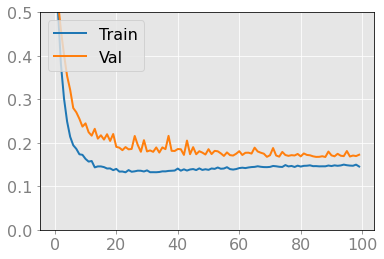

In [70]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.legend(['Train','Val'], loc='upper left')
plt.ylim(0,.5);

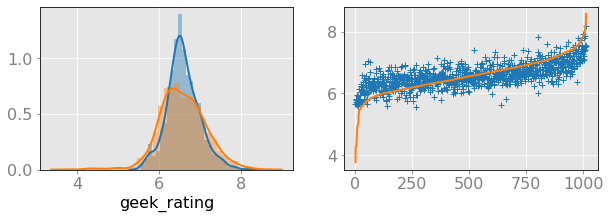

In [71]:
predict = model.predict(X_train)
fig = plt.figure(figsize = (10,3))
plt.subplot(1,2,1)
sns.distplot(predict)
sns.distplot(y_tr)
plt.subplot(1,2,2)
argsort = np.argsort(y_train)
plt.plot(predict[argsort],'+')
plt.plot(np.array(y_train)[argsort])

# END

In [ ]:
lmbd_list = 10**(np.linspace(-2,2,20))
a_list = np.linspace(0,1,10)
for i,lmbd in enumerate(tqdm(lmbd_list, position = 0)):  
    for j, a in enumerate(tqdm(a_list, position = 1, leave = False)):  
        pass

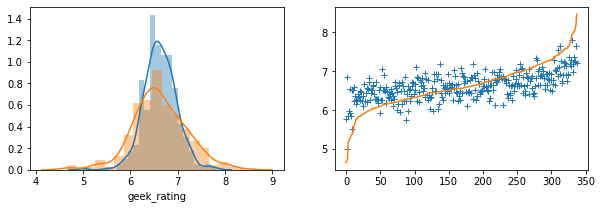

In [396]:
X_test = np.concatenate([X_te, dummy_scale_list[argmin[2]] * dummies_te],axis = 1)
X_test = X_test[:,col_mask]
X_test.shape
predict = model.predict(X_test)
fig = plt.figure(figsize = (10,3))
plt.subplot(1,2,1)
sns.distplot(predict)
sns.distplot(y_te)
plt.subplot(1,2,2)
argsort = np.argsort(y_te)
plt.plot(predict[argsort],'+')
plt.plot(np.array(y_te)[argsort])

In [42]:
pd.melt(pd.concat([y,df_dummies],axis = 1),id_vars=['geek_rating'])

,geek_rating,variable,value
0,7.006,pub_all_Edge Entertainment,0
1,7.313,pub_all_Edge Entertainment,0
2,7.523,pub_all_Edge Entertainment,0
3,7.667,pub_all_Edge Entertainment,0
4,7.527,pub_all_Edge Entertainment,0
...,...,...,...
175651,5.830,Crowdfunding: Kickstarter,0
175652,6.076,Crowdfunding: Kickstarter,0
175653,6.398,Crowdfunding: Kickstarter,0
175654,6.100,Crowdfunding: Kickstarter,0


In [43]:
frist_value_from_csv_col(df.publishers)

0                               KOSMOS
1                        Hans im Glück
2                    Z-Man Games, Inc.
3                     Repos Production
4                     Rio Grande Games
                     ...              
1705                          Arclight
1706    Ravensburger Spieleverlag GmbH
1707                        Black Monk
1708                       AURUM, Inc.
1709                      ABACUSSPIELE
Name: publishers, Length: 1710, dtype: object

In [44]:
number_of_items_csv_col(df.mechanisms).sort_values(ascending=False)

1638    18
733     16
38      15
352     13
76      13
        ..
670      1
1267     1
1083     1
1268     1
702      1
Name: mechanisms, Length: 1710, dtype: int64

In [45]:
value_counts_from_csv_col(df.artists)[:50]

Franz Vohwinkel              102
Michael Menzel                49
Harald Lieske                 44
(Uncredited)                  40
Klemens Franz                 38
Claus Stephan                 35
Chris Quilliams               32
Rodger B. MacGowan            31
Julien Delval                 29
Miguel Coimbra                27
Oliver Freudenreich           25
Henning Ludvigsen             24
Dennis Lohausen               24
Brian Schomburg               23
Vincent Dutrait               23
Cyrille Daujean               22
Tomasz Jedruszek              21
Mark Simonitch                20
Kurt Miller                   19
John Kovalic                  19
Doris Matthäus                17
Christof Tisch                17
Scott Nicely                  17
Arnaud Demaegd                17
Michaela Kienle               17
Peter Dennis                  17
Nicolas Fructus               17
Andrew Navaro                 15
Paul Niemeyer                 14
Josh Cappel                   14
Martin Hof